# Topic Modeling and Sentiment Analysis Rework

In [1]:
import pandas as pd
import pickle
import gensim
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim

from pprint import pprint
from gensim import corpora, models
from gensim.models import CoherenceModel

## Changes to the final project
In the original "the Language in News" project dominant topic bias and  class imbalance possibly hindered potential insights.  In an attempt to improve topic coherence and clustering, various methods and changes will be employed, including:
- Class imbalance will be dealt with by removing all South China Morning Post (SCMP) articles since it is the only local news source and produced various forms of bias in the data.
- Certain features (i.e. sentiment scores of topics) will be scaled in order to help alleviate bias from dominant topics.
- The entire articles will be used instead of the first 10 sentences.
- Bigram model created across all articles instead of per article (incorrectly applied in the final project).

## Additional cleaning of articles
A script and functions were written to remove 'SCMP' articles, articles before the protests, unwanted articles.  A pickled DataFrame ```df_topic.p``` with additional preprocessing (tokenization, bigram creation, and lemmatization) is returned by running the ```prep_for_tm.py``` file.

In [2]:
# %run 'prep_for_tm.py'

f = open('df_topic.p', 'rb')
df = pickle.load(f)
f.close()

In [3]:
df.head()

,url,date,headline,body,source,sentences,sentence_tokens,word_tokens,headline_tokens
0,https://www.reuters.com/article/idUSKBN21E11L,2020-03-27,Exclusive: Support for Hong Kong protesters' d...,Support for the demands of pro-democracy prote...,Reuters,[Support for the demands of pro-democracy prot...,[support demand protester hong_kong grow even ...,"[support, demand, protester, hong_kong, grow, ...","[exclusive, support, protester, demand, rise, ..."
1,https://www.reuters.com/article/idUSKBN21513Q,2020-03-18,Hong Kong rail operator ordered to release pol...,A Hong Kong court on Wednesday ordered rail op...,Reuters,[A Hong Kong court on Wednesday ordered rail o...,[order hand cctv_footage police operation prot...,"[order, hand, cctv_footage, police, operation,...","[order, release, police, protest, footage]"
2,https://www.reuters.com/article/idUSKBN2150JZ,2020-03-18,Exclusive: China's internal security force on ...,Officers from Chinas top internal security for...,Reuters,[Officers from Chinas top internal security fo...,[officer chinas_top internal force police join...,"[officer, chinas_top, internal, force, police,...","[exclusive, frontline, protest]"
3,https://www.reuters.com/article/idUSKBN20V0KN,2020-03-08,Hong Kong pro-democracy protesters hold vigil ...,"Hundreds of black-clad Hong Kong protesters, h...",Reuters,"[Hundreds of black-clad Hong Kong protesters, ...",[protester hold candle return parking lot stud...,"[protester, hold, candle, return, parking, lot...","[protester, hold, death]"
4,https://www.reuters.com/article/idUSL4N2AW1UI,2020-03-03,"Robert Walters' pretax profit falls, warns of ...",British recruiting firm Robert Walters Plcs an...,Reuters,[British recruiting firm Robert Walters Plcs a...,[british recruit firm plcs annual pretax profi...,"[british, recruit, firm, plcs, annual, pretax,...","[profit, fall, warn, likely, hit]"


In [4]:
data = df['word_tokens']
data2 = df['headline_tokens']
data3 = df['sentence_tokens']

In [83]:
id2word = corpora.Dictionary(data)
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)
corpus = [ id2word.doc2bow(datum) for datum in data ]

In [84]:
print(id2word)

Dictionary(3774 unique tokens: ['ability', 'abuse', 'accept', 'accord', 'act']...)


In [85]:
num_docs = len(data2)

## Topic modeling
Modeled on the collection of articles with standard LDA and LDA Mallet.  The topic counts with the highest coherence values for LDA and LDA Mallet were 12 topics with a coherence value of 0.398 and 16 topics with a coherence value of 0.452, respectively.  However, there are local maxima with greater interpretability at 3 topics:  0.382 (LDA) and 0.435 (LDA Mallet).

In [95]:
mallet_path = '/Users/waynelam/Documents/DevStuff/mallet-2.0.8/bin/mallet'

def compute_coherence_values(dictionary, corpus, texts, limit, num_docs=num_docs, start=2, step=3, mallet_path=None):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        if mallet_path:
            model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                     corpus=corpus,
                                                     workers=6,
                                                     id2word=dictionary,
                                                     num_topics=num_topics)
        else:
            model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               workers=6,
                                               num_topics=num_topics,
                                               random_state=100,
                                               chunksize=num_docs,
                                               passes=10)
            
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [102]:
start, limit, step = 2, 21, 1

In [103]:
model_list, coherence_values = compute_coherence_values(id2word,
                                                        corpus,
                                                        data,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

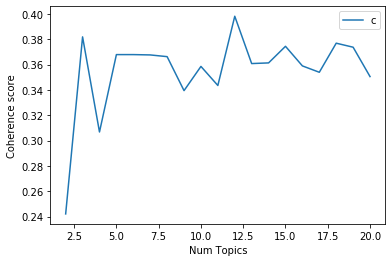

In [104]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [122]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       workers=6,
                                       num_topics=3,
                                       minimum_probability=0.75,
                                       random_state=100,
                                       chunksize=num_docs,
                                       passes=10)

In [123]:
pprint(lda_model.print_topics())

[(0,
  '0.008*"year" + 0.008*"market" + 0.005*"company" + 0.005*"fall" + '
  '0.005*"trade" + 0.004*"share" + 0.004*"rise" + 0.004*"support" + '
  '0.004*"investor" + 0.004*"business"'),
 (1,
  '0.025*"police" + 0.006*"city" + 0.006*"violence" + 0.006*"use" + '
  '0.005*"call" + 0.005*"student" + 0.005*"many" + 0.005*"see" + '
  '0.004*"include" + 0.004*"demonstration"'),
 (2,
  '0.010*"would" + 0.005*"call" + 0.005*"make" + 0.005*"include" + '
  '0.005*"could" + 0.005*"take" + 0.005*"support" + 0.004*"political" + '
  '0.004*"law" + 0.004*"police"')]


In [124]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.46115643193931

Coherence Score:  0.38181015988793937


In [105]:
model_list, coherence_values = compute_coherence_values(id2word,
                                                        corpus,
                                                        data,
                                                        start=start,
                                                        limit=limit,
                                                        step=step,
                                                        mallet_path=mallet_path)

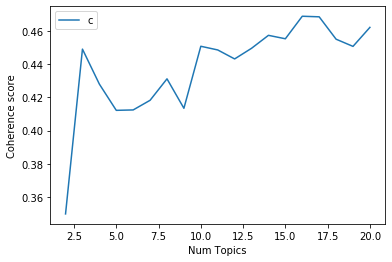

In [106]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [125]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             random_seed=100,
                                             num_topics=3,
                                             topic_threshold=0.75,
                                             workers=6,
                                             id2word=id2word)
ldamallet.print_topics()

[(0,
  '0.015*"year" + 0.011*"company" + 0.010*"business" + 0.010*"market" + 0.008*"month" + 0.008*"week" + 0.007*"time" + 0.007*"expect" + 0.007*"share" + 0.007*"fall"'),
 (1,
  '0.037*"police" + 0.014*"city" + 0.012*"violence" + 0.008*"student" + 0.008*"demonstration" + 0.008*"call" + 0.007*"group" + 0.007*"arrest" + 0.007*"street" + 0.007*"activist"'),
 (2,
  '0.011*"make" + 0.011*"support" + 0.010*"law" + 0.007*"political" + 0.007*"call" + 0.007*"include" + 0.007*"work" + 0.007*"official" + 0.006*"situation" + 0.006*"add"')]

In [126]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet,
                                           texts=data,
                                           dictionary=id2word,
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4348141139316595


In [ ]:
mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)